The current model nicely predicts that the optimal study gap between two sessions should increase as the test delay increases. Here I will test what the model predicts the gaps should be between more than two successive sessions. I see three options:
* Equal gaps
* Increasing gaps
* Decreasing gaps

Intuition tells me that gaps should be increasing. Let's see what the model predicts

In [6]:
library(tidyverse)
library(colorRamps)
options(repr.plot.width=6, repr.plot.height=4)

base <- function(t, currentTime, p=0.5, d=0.5) {
  # the first increment is just p
  B=0
  deltaB = p
  # for every increment after that, check if it has occured yet (t[i] <= currentTime)
  # if it has occured, calculate B at time t[i], which is multiplying each increment 
  # by the forgetting function of how much time has passed since then
  # finally, calculate the current increment size based on B
  for (i in 2:length(t)) {
    if (t[i] <= currentTime) {
      B = sum(deltaB * (1 + t[i] - t[1:(i-1)])^(-d))
      deltaB[i] = p * (1-B)
    }
  }
  # set the time to 0 if the event hasn't occured yet (-1, because of the 1+time in the eq below
  # then calculate B at the current time)
  time = ifelse(currentTime - t[1:length(deltaB)] < 0, -1, currentTime - t[1:length(deltaB)])
  B = sum(deltaB * (1 + time)^(-d))
  return(B)
}

# generate data
data_log <- expand.grid(gap12=seq(0,8,0.1), gap23=seq(0,8,0.1), delay=seq(0,5,1))
data <- 10 ** data_log
data <- as.data.frame(data)
data$b <- apply(data, 1, function(x) base(c(0, x[1], x[1]+x[2]), x[1]+x[2]+x[3], p=0.65, d=0.2))


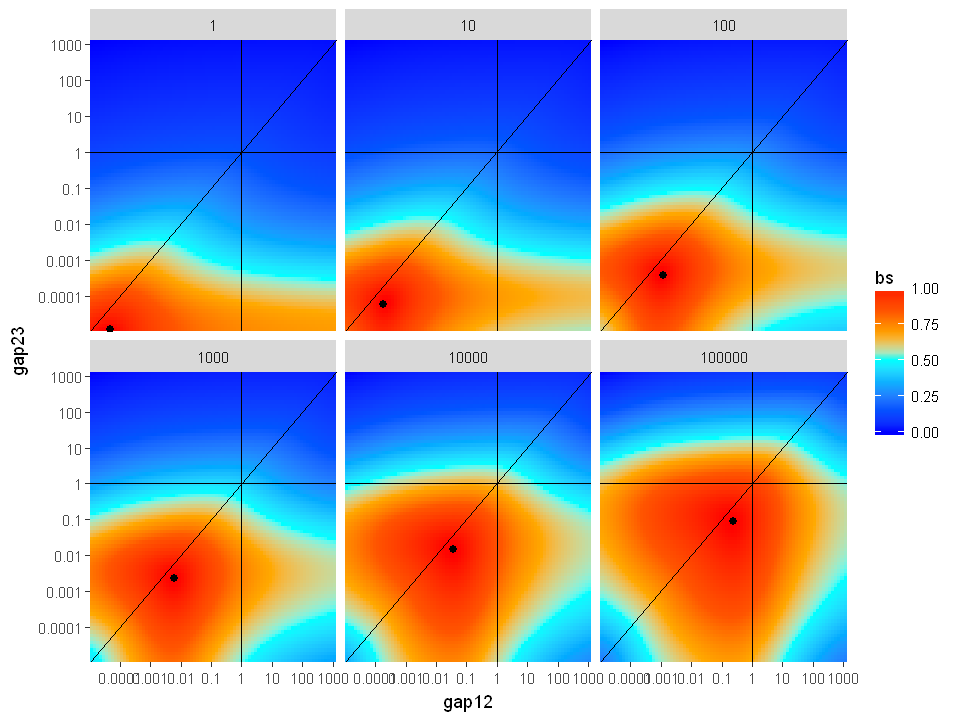

In [72]:
options(scipen=10000)
options(repr.plot.width=8, repr.plot.height=6)
breaks = c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000)

tmp <- data %>% 
  group_by(delay) %>% 
  mutate(bs = (b-min(b))/max(b-min(b))) %>% 
  mutate(maxb = bs == 1) %>%
  ungroup()  %>% 
  mutate(gap12 = gap12/86400, 
         gap23 = gap23/86400)

tmp  %>% 
  ggplot(aes(gap12, gap23, fill=bs)) +
  geom_tile()  +
  facet_wrap(~delay) +
  geom_point(data=tmp %>% filter(maxb==TRUE), aes(x=gap12, y=gap23), color='black', size=2) +
  scale_fill_gradientn(colours=blue2red(7)) +
  scale_x_log10(breaks=breaks, labels = breaks, expand = c(0, 0)) +
  scale_y_log10(breaks=breaks, labels=breaks, expand = c(0, 0)) +
  geom_hline(yintercept = 1) +
  geom_vline(xintercept = 1) +
  geom_abline(intercept = 0, slope=1) +
  theme(panel.grid = element_blank(), panel.border = element_blank())

This plot shows that, surprisingly, the second gap should always be smaller than the first gap for optimal performance, given a fixed test delay. As the test delay increases, both gaps increase, but again the second gap remains smaller. The plot below summarizes the optimal gaps for different values of test delay

In [52]:
# generate data
data_log <- expand.grid(gap12=seq(0,8,0.1), gap23=seq(0,8,0.1), delay=seq(0,5,0.1))
data <- 10 ** data_log
data <- as.data.frame(data)
data$b <- apply(data, 1, function(x) base(c(0, x[1], x[1]+x[2]), x[1]+x[2]+x[3], p=0.65, d=0.2))

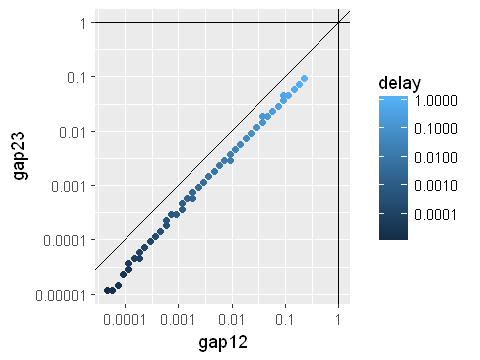

In [91]:
options(repr.plot.width=4, repr.plot.height=3)
tmp <- data %>% 
  group_by(delay) %>% 
  mutate(bs = (b-min(b))/max(b-min(b))) %>% 
  mutate(maxb = bs == 1) %>%
  ungroup()  %>% 
  mutate(gap12 = gap12/86400, 
         gap23 = gap23/86400,
         delay = delay/86400)  %>% 
  filter(maxb)
    
tmp  %>% 
  ggplot(aes(gap12, gap23, color=delay)) +
  geom_point() +
  scale_x_log10(breaks=breaks, labels = breaks) +
  scale_y_log10(breaks=breaks, labels=breaks) +
  scale_color_gradient(trans='log10', breaks=breaks) +
  geom_hline(yintercept = 1) +
  geom_vline(xintercept = 1) +
  geom_abline(intercept = 0, slope=1)

Why is this the case? Well, when the second gap increases, so does the test delay with respect to the first and second repetitions. For example, for two different cases

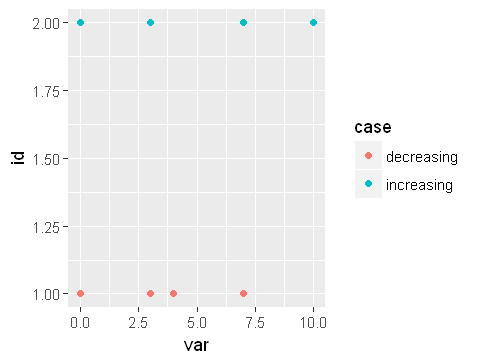

In [102]:
data.frame(case = c('decreasing','increasing'), id=c(1,2), x1 = c(0,0), x2 = c(3,3), x3 = c(4, 7), x4 = c(7, 10))  %>% 
    gather(key, var, -case, -id)  %>% 
    ggplot(aes(var, id, color=case)) +
    geom_point()

Let's consider another case where vary both the total duration (testtime - first_study) and the test delay (testtime - last_study)

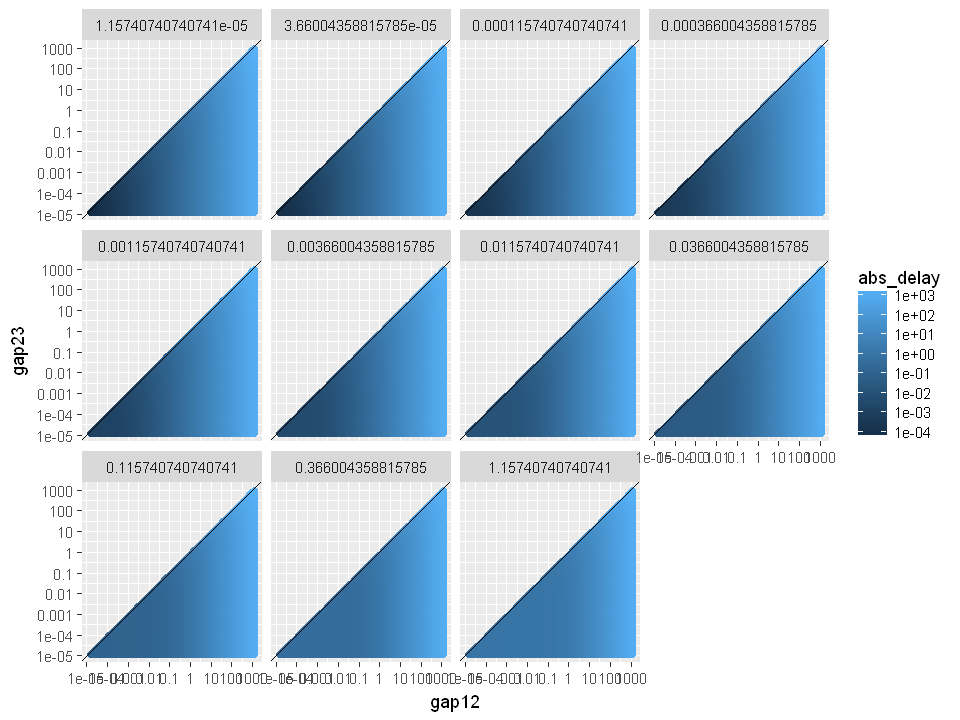

In [58]:
# generate data
breaks = c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000)
data_log <- expand.grid(gap12=seq(0,8,0.1), gap23=seq(0,8,0.1), delay=seq(0,5,0.5))
data <- 10 ** data_log
data <- as.data.frame(data)
data$abs_delay = data$gap12+data$gap23+data$delay
data$b <- apply(data, 1, function(x) base(c(0, x[1], x[1]+x[2]), x[4], p=0.65, d=0.2))

tmp <- data %>% 
  group_by(delay, abs_delay) %>% 
  mutate(bs = (b-min(b))/max(b-min(b))) %>% 
  mutate(maxb = bs == 1) %>%
  ungroup()  %>% 
  mutate(gap12 = gap12/86400, 
         gap23 = gap23/86400,
         delay = delay/86400,
         abs_delay = abs_delay/86400)  %>% 
  filter(maxb)
    
options(repr.plot.width=8, repr.plot.height=6)
tmp  %>% 
  ggplot(aes(gap12, gap23, color=abs_delay)) +
  geom_point() +
  scale_x_log10(breaks=breaks, labels = breaks) +
  scale_y_log10(breaks=breaks, labels=breaks) +
  scale_color_gradient(trans='log10', breaks=breaks) +
  geom_abline(intercept = 0, slope=1) +
  facet_wrap(~delay)

Turns out the optimal is never with increasing gaps. Let's rank optimality as a function of gap12/gap23 ratio

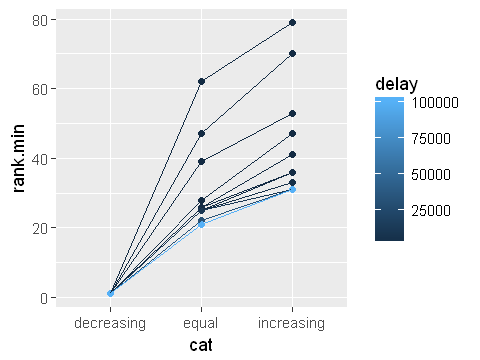

In [59]:
options(repr.plot.width=4, repr.plot.height=3)
data  %>% 
    mutate(ratio = gap12/gap23)  %>% 
    arrange(delay, desc(b))  %>% 
    group_by(delay)  %>% 
    mutate(rank = 1:length(delay),
           cat = ifelse(ratio < 1, 'increasing',ifelse(ratio > 1, 'decreasing', 'equal')))  %>% 
    group_by(delay, cat)  %>% 
    summarise(rank.mean = mean(rank),
              rank.min = min(rank))  %>% 
    ggplot(aes(cat, rank.min, color=delay, group=delay)) +
    geom_point() +
    geom_line()
    

So, optimal decreasing is always better than optimal equal, which in turn is always better than optimal increasing intervals.

Let's calculate percentage of cases in which each category is better than the others

In [60]:
percents <- data  %>% 
    mutate(ratio = gap12/gap23)  %>% 
    arrange(delay, desc(b))  %>% 
    group_by(delay)  %>% 
    mutate(rank = 1:length(delay),
           cat = ifelse(ratio < 1, 'increasing',ifelse(ratio > 1, 'decreasing', 'equal')))  %>% 
    group_by(delay)  %>% 
    summarize(pIncGreaterDec = sapply(b[cat == 'increasing'], function(x) x > b[cat == 'decreasing'])  %>% mean(),
            pIncGreaterEq = sapply(b[cat == 'increasing'], function(x) x > b[cat == 'equal'])  %>% mean(),
            pEqGreaterDec = sapply(b[cat == 'equal'], function(x) x > b[cat == 'decreasing'])  %>% mean())

In [61]:
percents

delay,pIncGreaterDec,pIncGreaterEq,pEqGreaterDec
1.000000e+00,0.2057466,0.3216126,0.4134126
3.162278e+00,0.2089204,0.3213344,0.4207209
1.000000e+01,0.2151724,0.3218031,0.4318320
3.162278e+01,0.2252526,0.3237349,0.4436786
1.000000e+02,0.2388032,0.3275453,0.4528578
3.162278e+02,0.2549958,0.3332038,0.4588058
1.000000e+03,0.2731050,0.3409351,0.4631192
3.162278e+03,0.2925030,0.3504496,0.4662780
1.000000e+04,0.3125012,0.3621437,0.4688081
3.162278e+04,0.3324356,0.3757697,0.4706561


No summary function supplied, defaulting to `mean_se()


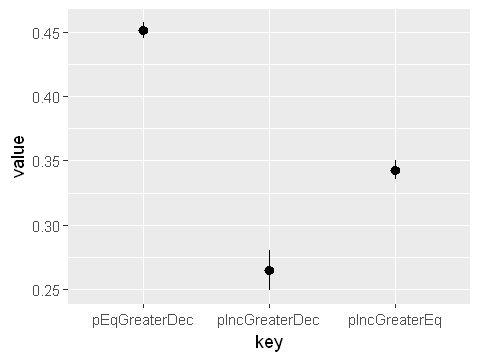

In [62]:
percents  %>% 
    gather(key, value, -delay)  %>% 
    ggplot(aes(key, value)) +
    stat_summary()

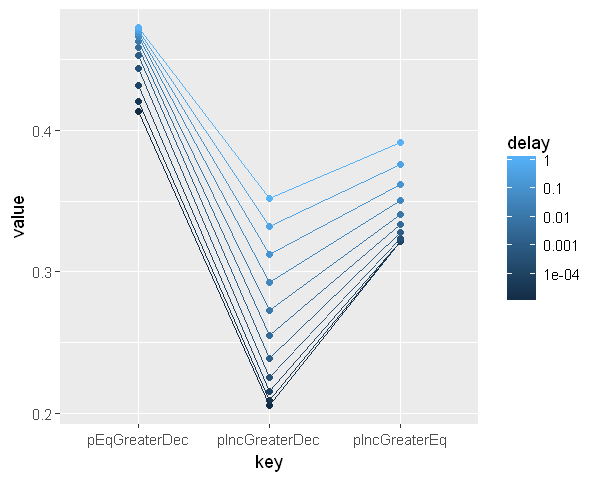

In [63]:
options(repr.plot.width=5, repr.plot.height=4)
percents  %>% 
    mutate(delay = delay/86400)  %>% 
    gather(key, value, -delay)  %>% 
    ggplot(aes(key, value, color=delay, group=delay)) +
    geom_point() +
    geom_line() +
    scale_color_gradient(trans='log10', breaks=breaks, labels=breaks)

Ok, so when the delay gets longer, the average proportion of cases in which increasing gaps is better than decreasing gaps gets bigger. So maybe I should look into expanding the range into multiday values

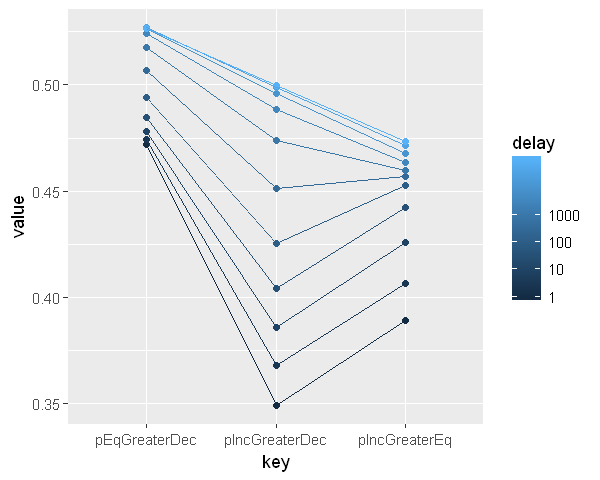

In [64]:
# generate data
breaks = c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000)
data_log <- expand.grid(gap12=seq(0,8,0.1), gap23=seq(0,8,0.1), delay=seq(0,5,0.5))
data <- 10 ** data_log
data <- as.data.frame(data)
data$delay <- data$delay * 86400
data$abs_delay = data$gap12+data$gap23+data$delay
data$b <- apply(data, 1, function(x) base(c(0, x[1], x[1]+x[2]), x[4], p=0.65, d=0.2))
    
percents <- data  %>% 
    mutate(ratio = gap12/gap23)  %>% 
    arrange(delay, desc(b))  %>% 
    group_by(delay)  %>% 
    mutate(rank = 1:length(delay),
           cat = ifelse(ratio < 1, 'increasing',ifelse(ratio > 1, 'decreasing', 'equal')))  %>% 
    group_by(delay)  %>% 
    summarize(pIncGreaterDec = sapply(b[cat == 'increasing'], function(x) x > b[cat == 'decreasing'])  %>% mean(),
            pIncGreaterEq = sapply(b[cat == 'increasing'], function(x) x > b[cat == 'equal'])  %>% mean(),
            pEqGreaterDec = sapply(b[cat == 'equal'], function(x) x > b[cat == 'decreasing'])  %>% mean())
    

percents  %>% 
    mutate(delay = delay/86400)  %>% 
    gather(key, value, -delay)  %>% 
    ggplot(aes(key, value, color=delay, group=delay)) +
    geom_point() +
    geom_line() +
    scale_color_gradient(trans='log10', breaks=breaks, labels=breaks)

Let's test more repetitions and see whether it is generally decreasing lags that are optimal

In [84]:
# generate data
data_log <- expand.grid(gap12=seq(0,8,0.5), gap23=seq(0,8,0.5), gap34=seq(0,8,0.5), delay=seq(0,8,0.25))
data <- 10 ** data_log
data <- as.data.frame(data)
data$b <- apply(data, 1, function(x) base(c(0, x[1], x[1]+x[2],x[1]+x[2]+x[3]), x[1]+x[2]+x[3]+x[4], p=0.65, d=0.2))

In [85]:
options(repr.plot.width=4, repr.plot.height=3)
options(scipen = 10000)
tmp <- data %>% 
  group_by(delay) %>% 
  mutate(bs = (b-min(b))/max(b-min(b))) %>% 
  mutate(maxb = bs == 1) %>%
  ungroup()  %>% 
  mutate(gap12 = gap12/86400, 
         gap23 = gap23/86400,
         gap34 = gap34/86400,
         delay = delay/86400)  %>% 
  filter(maxb)

In [86]:
tmp

gap12,gap23,gap34,delay,b,bs,maxb
0.0001157407,0.00003660044,0.00001157407,0.00001157407,0.90221013,1,TRUE
0.0001157407,0.00003660044,0.00001157407,0.00002058194,0.87900494,1,TRUE
0.0001157407,0.00003660044,0.00001157407,0.00003660044,0.84749290,1,TRUE
0.0003660044,0.00011574074,0.00003660044,0.00006508580,0.81475360,1,TRUE
0.0003660044,0.00011574074,0.00003660044,0.00011574074,0.77811214,1,TRUE
0.0003660044,0.00036600436,0.00011574074,0.00020581938,0.73680754,1,TRUE
0.0011574074,0.00036600436,0.00011574074,0.00036600436,0.69832078,1,TRUE
0.0011574074,0.00036600436,0.00011574074,0.00065085802,0.65601256,1,TRUE
0.0011574074,0.00115740741,0.00036600436,0.00115740741,0.61446052,1,TRUE
0.0036600436,0.00115740741,0.00036600436,0.00205819376,0.57374465,1,TRUE


In [83]:
tmp$gap12/tmp$delay

[1] 10.0000000  5.6234133  3.1622777  5.6234133  3.1622777  1.7782794
 [7]  3.1622777  1.7782794  1.0000000  1.7782794  1.0000000  0.5623413
[13]  1.0000000  0.5623413  0.3162278  0.5623413  0.3162278  0.5623413
[19]  0.3162278  0.1778279  0.3162278

Generally, decreasing intervals by 3 times each lead to optimal results according to the model. For example, if the test is 2 months days after the last study sessions, the lags should be ~ 12 days, 4 days, 1 day or sequece:

* Day 0: STUDY
* Day 12: STUDY
* Day 16: STUDY
* Day 17: STUDY
* Day 77: TEST

In [104]:
bestincreasing <- data  %>% 
    mutate(gap12 = gap12/86400, 
             gap23 = gap23/86400,
             gap34 = gap34/86400,
             delay = delay/86400)  %>% 
    filter(delay < 70, delay > 60)  %>% 
    arrange(desc(b))  %>% 
    filter(gap12 < gap23, gap23 < gap34) 
bestincreasing <- bestincreasing[1:4,]

bestdecreasing <- data  %>% 
    mutate(gap12 = gap12/86400, 
             gap23 = gap23/86400,
             gap34 = gap34/86400,
             delay = delay/86400)  %>% 
    filter(delay < 70, delay > 60)  %>% 
    arrange(desc(b))  %>% 
    filter(gap12 > gap23, gap23 > gap34) 
bestdecreasing <- bestdecreasing[1:4,]

bestequal <- data  %>% 
    mutate(gap12 = gap12/86400, 
             gap23 = gap23/86400,
             gap34 = gap34/86400,
             delay = delay/86400)  %>% 
    filter(delay < 70, delay > 60)  %>% 
    arrange(desc(b))  %>% 
    filter(gap12 == gap23, gap23 == gap34) 
bestequal <- bestequal[1:4,]

bestincreasing; bestdecreasing; bestequal


gap12,gap23,gap34,delay,b
0.3660044,1.157407,3.660044,65.0858,0.1051270
1.1574074,3.660044,11.574074,65.0858,0.1049524
0.1157407,1.157407,3.660044,65.0858,0.1045334
0.3660044,3.660044,11.574074,65.0858,0.1045214


gap12,gap23,gap34,delay,b
11.574074,3.660044,1.1574074,65.0858,0.1064269
11.574074,3.660044,0.3660044,65.0858,0.1061009
11.574074,1.157407,0.3660044,65.0858,0.1057588
3.660044,1.157407,0.3660044,65.0858,0.1056266


gap12,gap23,gap34,delay,b
3.6600436,3.6600436,3.6600436,65.0858,0.1063543
1.1574074,1.1574074,1.1574074,65.0858,0.1055466
11.5740741,11.5740741,11.5740741,65.0858,0.1048287
0.3660044,0.3660044,0.3660044,65.0858,0.1034933


The differences are not that big. In the example above, best ~= 0.10, worst ~= 0.05. And  the difference between the best decreasing and best increasing is ~0.1%

In [111]:
bestincreasing <- data  %>% 
    mutate(gap12 = gap12/86400, 
             gap23 = gap23/86400,
             gap34 = gap34/86400,
             delay = delay/86400)  %>% 
    filter(delay < 0.1, delay > 0.01)  %>% 
    arrange(desc(b))  %>% 
    filter(gap12 < gap23, gap23 < gap34) 
bestincreasing <- bestincreasing[1:4,]

bestdecreasing <- data  %>% 
    mutate(gap12 = gap12/86400, 
             gap23 = gap23/86400,
             gap34 = gap34/86400,
             delay = delay/86400)  %>% 
    filter(delay < 0.1, delay > 0.01)  %>% 
    arrange(desc(b))  %>% 
    filter(gap12 > gap23, gap23 > gap34) 
bestdecreasing <- bestdecreasing[1:4,]

bestequal <- data  %>% 
    mutate(gap12 = gap12/86400, 
             gap23 = gap23/86400,
             gap34 = gap34/86400,
             delay = delay/86400)  %>% 
    filter(delay < 0.1, delay > 0.01)  %>% 
    arrange(desc(b))  %>% 
    filter(gap12 == gap23, gap23 == gap34) 
bestequal <- bestequal[1:4,]

bestincreasing; bestdecreasing; bestequal


gap12,gap23,gap34,delay,b
0.0003660044,0.001157407,0.003660044,0.01157407,0.4353356
0.0011574074,0.003660044,0.011574074,0.01157407,0.4343202
0.0003660044,0.003660044,0.011574074,0.01157407,0.4282089
0.0001157407,0.001157407,0.003660044,0.01157407,0.4273892


gap12,gap23,gap34,delay,b
0.01157407,0.003660044,0.0011574074,0.01157407,0.4555751
0.01157407,0.003660044,0.0003660044,0.01157407,0.4506047
0.03660044,0.003660044,0.0011574074,0.01157407,0.4498128
0.03660044,0.011574074,0.0011574074,0.01157407,0.4469158


gap12,gap23,gap34,delay,b
0.003660044,0.003660044,0.003660044,0.01157407,0.4531740
0.001157407,0.001157407,0.001157407,0.01157407,0.4425993
0.011574074,0.011574074,0.011574074,0.01157407,0.4391186
0.003660044,0.003660044,0.003660044,0.02058194,0.4161666


Here the differences are a little bit more pronounced, but not by much (~2%). It will be very difficult to detect. Above is an example with test delay of 27 minutes.